In [1]:
from IPython.display import clear_output
from enum import Enum
import numpy as np
import random
import os
import time
import sys
import matplotlib.pylab as plt
%matplotlib inline 
import seaborn as sns

In [2]:
class ElevatorTypes(Enum):
    shabbat = 'shabbat'
    ordinary = 'ordinary'

class ElevatorFactory():
    """
    Factory that returns instances of different types of elevators
    """
    def get_elevator(num_floors, elevator_type, requests=[], capacity=5):
        if elevator_type == ElevatorTypes.shabbat:
            return ShabbatElevator(num_floors, requests, capacity)
        elif elevator_type == ElevatorTypes.ordinary:
            return OrdinaryElevator(num_floors, requests, capacity)
        else:
            return None
    get_elevator = staticmethod(get_elevator)

class AbstractElevator():
    """
    Class representing the Elevator entity in the simulation

    Attributes:
        num_floors: Number of floors in the building indexed from 0 to num_floors-1
        requests: List of requests from all the passengers, this is specified at once in the start by user
        capacity: Maximum number of passengers that the elevator could carry
        curr_floor: The floor that the elevator is currently on
        direction: Indicator whether the elevator is moving up or down
        num_passengers: number of passengers currently in the elevator
    """

    DEFAULT_NUM_PASSENGERS = 0
    STARTING_FLOOR = 0

    # Directions
    DIRECTION_UP = 0
    DIRECTION_DOWN = 1

    def __init__(self, num_floors, requests=[], capacity=5):
        self.num_floors = num_floors
        self.requests = requests
        self.capacity = capacity

        self.curr_floor = self.STARTING_FLOOR
        self.direction = self.DIRECTION_UP
        self.num_passengers = self.DEFAULT_NUM_PASSENGERS

    def move(self):
        raise NotImplementedError()

    def all_requests_completed(self):
        for request in self.requests:
            if not request.at_destination:
                return False

        return True
    
    def requests_served(self):
        return 1 + sum([request.at_destination 
                        for request in self.requests])

    def is_moving_up(self):
        return self.direction == self.DIRECTION_UP

class ShabbatElevator(AbstractElevator):
    """
    Elavator that inherits from the Abstract elevator class
    and moves with the logic of a Shabbat elevator
    """
    def __init__(self, num_floors, requests=[], capacity=5):
        AbstractElevator.__init__(self, num_floors, requests, capacity)

    def move(self):
        """
        Moving logic for the elevator: moves by one floor, either up or down
        Switches direction when it reaches top/bottom floor

        Return: Number of floors travelled
        """

        # Change direction if on top/bottom floor
        if self.curr_floor == 0:
            self.direction = self.DIRECTION_UP
        elif self.curr_floor == self.num_floors - 1:
            self.direction = self.DIRECTION_DOWN

        # Move by 1 floor depending on direction
        if self.direction == self.DIRECTION_UP:
            self.curr_floor += 1
        elif self.direction == self.DIRECTION_DOWN:
            self.curr_floor -= 1

        return 1

class OrdinaryElevator(AbstractElevator):
    """
    Elavator that inherits from the Abstract elevator class
    and moves like an ordinary elevator
    """
    def __init__(self, num_floors, requests=[], capacity=5):
        AbstractElevator.__init__(self, num_floors, requests, capacity)

    def move(self):
        """
        Moving logic for the elevator: Take on request that is on the closest
        floor in the direction of movement. If there are no requests in the
        direction of movement, change direction.

        Return: Number of floors travelled
        """
        # Find closest request in each direction
        closest_up_request = float('inf')
        closest_down_request = float(-1)
        
        for passenger in self.requests:
            if passenger.at_destination:
                continue

            if passenger.in_elevator:
                # For passengers in the elevator get destination floor
                floor_request = passenger.destination
            else:
                # For passengers outside the elevator get pickup floor
                floor_request = passenger.current

            # Check direction of request and if it's closer than the current closest
            if floor_request > self.curr_floor and \
                floor_request < closest_up_request:

                closest_up_request = floor_request
            elif floor_request < self.curr_floor and \
                floor_request > closest_down_request:

                closest_down_request = floor_request

        prev_floor = self.curr_floor

        # Move to closest floor and update direction if needed
        if self.direction == self.DIRECTION_UP:
            if closest_up_request != float('inf'):
                self.curr_floor = closest_up_request
            else:
                self.direction = self.DIRECTION_DOWN
                self.curr_floor = closest_down_request
        else:
            if closest_down_request != float(-1):
                self.curr_floor = closest_down_request
            else:
                self.direction = self.DIRECTION_UP
                self.curr_floor = closest_up_request

        return abs(prev_floor - self.curr_floor)

In [3]:
class Passenger():
    """
    Class representing the Passenger entity in the simulation

    Attributes:
        id: unique identified of passenger
        current: The floor which the passenger comes from
        destination: The floor which the passenger wants to go to
        in_elevator: Is passenger currently in the elevator or waiting outside
        at_destination: Is passenger delivered to their destination
    """

    DEFAULT_IS_INSIDE = False
    DEFAULT_AT_DESTINATION = False

    def __init__(self, index, num_floors):
        self.id = index

        journey = self._assign_journey(num_floors)
        self.current = journey[0]
        self.destination = journey[1]

        self.in_elevator = self.DEFAULT_IS_INSIDE
        self.at_destination = self.DEFAULT_AT_DESTINATION

    def _assign_journey(self, num_floors):
        """
        Output starting floor and ending floor, making sure that they differ,
        and biasing towards starting or ending at the lobby.
        """
        curr = [0 if np.random.random() < 0.5
                  else np.random.randint(1, num_floors)]

        dest = [0 if np.random.random() < 0.5
                  else np.random.randint(1, num_floors)]

        # Ensure that current floor != destination floor
        while curr == dest:
            dest = [0 if np.random.random() < 0.5
                      else np.random.randint(1, num_floors)]

        return(curr[0], dest[0])

    def __repr__(self):
        return str(self.id)

    def __str__(self):
        return repr(self)

In [61]:
class Building():
    """
    Class representing the Building entity in the simulation

    Attributes:
        num_floors: number of floors in the building indexed from 0 to num_floors-1
        passenger_list: list of passengers
    """
    def __init__(self, num_floors, passenger_list):
        self.num_floors = num_floors
        self.passenger_list = passenger_list


    def get_passengers_on_floor(self, floor):
        passenger_count = 0

        for passenger in self.passenger_list:
            if passenger.in_elevator == False and passenger.current == floor:
                passenger_count += 1

        return passenger_count

In [62]:
class SimulationEngine():
    """
    Class responsible for running the simulation by working with the Building,
    Passengers, and Elevator classes

    Attributes:
        num_floors: number of floors in the building indexed from 0 to num_floors-1
        passenger_list: list of passengers
        elevator: elevator class used in the building
        building: building class
    """

    END_MESSAGE = "All passengers have been served - End of simulation"
    TIME_MESSAGE = "Average journey time: %s"
    MOVE_MESSAGE = "Elevator moved from floor %s to floor %s"
    PICKUP_MESSAGE = "Elevator picks up passenger %s at floor %s"
    DROPOFF_MESSAGE = "Elevator drops off passenger %s at floor %s"

    COLUMN_NAMES = ["Elevator", "|", "Floor", "# people"]
    FLOOR_FORMAT = "{:>10}" * len(COLUMN_NAMES)
    ELEVATOR_ON_FLOOR = "X"
    NO_ELEVATOR = " "
    DELIMITER = "|"

    TIME_PER_FLOOR = 1.5
    STOP_TIME = 6

    def __init__(self, num_floors, total_passengers, elevator_type, capacity, should_plot = True):
        self.num_floors = num_floors
        self.total_passengers = total_passengers
        self.elevator_type = elevator_type
        self.elevator_capacity = capacity
        self.should_plot = should_plot

        # Initialize passengers, elevator, and Building
        self.reset()

    def reset(self):
        """
        Initializes/resets the simulation to its initial state
        """
        # Generate a list of passengers based on total number of passengers
        self.passenger_list = [Passenger(i, self.num_floors)
                                    for i in range(1, self.total_passengers + 1)]

        self.elevator = ElevatorFactory.get_elevator(self.num_floors,
                                    self.elevator_type, self.passenger_list, self.elevator_capacity)
        
        self.building = Building(self.num_floors, self.passenger_list)


    def run(self):
        """
        Main method for simulation. The while True loop continues until
        all requests are fulfilled
        """
        self._print_state([], 0, True)
        total_wait_time = 0
        distance_moved = 0

        while True:
            # Used to print current state
            passenger_movements = []

            # Pick-up/drop-off passengers on current floor
            for passenger in self.elevator.requests:
                if passenger.at_destination:
                    continue

                # Add time waited to total
                total_wait_time += distance_moved * self.TIME_PER_FLOOR + self.STOP_TIME

                # Try pick-up
                pickup_move = self._pickup_passenger(passenger)
                # If passenger entered the elevator, store movement
                if pickup_move is not None:
                    passenger_movements.append(pickup_move)

                # Try drop-off
                dropoff_move = self._dropoff_passenger(passenger)
                # If passenger left the elevator, store movement
                if dropoff_move is not None:
                    passenger_movements.append(dropoff_move)

            # If there is no request left, we end the simulation and break the loop.
            if self.elevator.all_requests_completed():
                average_journey = 0
                if self.total_passengers != 0:
                    average_journey = total_wait_time / self.total_passengers
                
                if self.should_plot:
                    print(self.END_MESSAGE)
                    print(self.TIME_MESSAGE % (average_journey))

                return average_journey

            distance_moved = self.elevator.move()
            self._print_state(passenger_movements, distance_moved)


    def _pickup_passenger(self, passenger):
        """
        Pick-up passenger given that elevator is on the floor
        and the maximum capacity is not reached
        """
        if passenger.current == self.elevator.curr_floor \
                and passenger.in_elevator == False \
                and self.elevator.num_passengers < self.elevator.capacity:

            passenger.in_elevator = True
            self.elevator.num_passengers += 1

            return (self.PICKUP_MESSAGE %
                  (passenger.id, self.elevator.curr_floor))

        return None

    def _dropoff_passenger(self, passenger):
        """
        Drop-off passenger given that the destination is reached
        """
        if passenger.destination == self.elevator.curr_floor \
                and passenger.in_elevator == True:
            
            self.elevator.num_passengers -= 1
            passenger.at_destination = True

            return (self.DROPOFF_MESSAGE %
                   (passenger.id, self.elevator.curr_floor))

        return None

    def _print_state(self, passenger_movements, distance_moved, initial=False):
        """
        Prints the current state of the simulation
        """
        if not self.should_plot:
            return

        # Clear output
        os.system('clear')
        clear_output(wait=True)

        # Illustration of current state
        print (self.FLOOR_FORMAT.format(*self.COLUMN_NAMES))

        for floor in range(self.num_floors - 1, -1, -1):
            floor_elements = []

            if floor == self.elevator.curr_floor:
                floor_elements.append(self.ELEVATOR_ON_FLOOR)
            else:
                floor_elements.append(self.NO_ELEVATOR)

            floor_elements.append(self.DELIMITER)
            floor_elements.append(floor)
            floor_elements.append(str(self.building.get_passengers_on_floor(floor)))

            print (self.FLOOR_FORMAT.format(*floor_elements))

        if initial:
            time.sleep(1)
            return

        print("=" * 50)
        print("Number of people in elevator while moving: %s" % self.elevator.num_passengers)
        print("Number of passengers who have received service: %s out of %s" 
                      % (self.elevator.requests_served(), len(self.elevator.requests)))

        # Display next elevator movement
        if self.elevator.is_moving_up():
            print (self.MOVE_MESSAGE %
                    (self.elevator.curr_floor - distance_moved, self.elevator.curr_floor))
        elif not self.elevator.is_moving_up():
            print (self.MOVE_MESSAGE
                        % (self.elevator.curr_floor + distance_moved, self.elevator.curr_floor))


        # Display passenger movements
        print("=" * 50)
        for movement in passenger_movements:
            print(movement)

        time.sleep(1)

In [63]:
############################
### Test Simulation Here ###
############################

def main():
    try:
        #User inputs number of passengers and number of floors
        total_passengers = int(input("How many passengers are there?: "))
        total_floors = int(input("How many floors are there?: "))
        capacity = int(input("How many passengers can fit in the elevator?: "))

        simulation = SimulationEngine(total_floors, total_passengers,
                                        ElevatorTypes.ordinary, capacity)

        simulation.run()

    except ValueError:
        print ("Invalid input, please try again")
        main()

main()

  Elevator         |     Floor  # people
         X         |         2         0
                   |         1         0
                   |         0         0
Number of people in elevator while moving: 1
Number of passengers who have received service: 9 out of 9
Elevator moved from floor 1 to floor 2
Elevator drops off passenger 9 at floor 1
All passengers have been served - End of simulation
Average journey time: 28.5


In [ ]:
def test_strategy_by_passengers(total_floors, strategy):
    """
    Runs a strategy with different number of passengers
    """
    tests = {}
    capacity = 5
    
    for i in range(0,1100,100):
        total_passengers = i
        average = []
        
        # Run simulation 10 times and take the average
        for j in range(10):
            simulation = SimulationEngine(total_floors, total_passengers,
                                           strategy, capacity, False)
            result = simulation.run()
            average.append(result)
            simulation.reset()
    
        tests[i] = np.mean(average)
    return(tests)

def test_strategy_by_floors(num_passengers, strategy):
    """
    Runs a strategy with different number of floors
    """
    tests = {}
    capacity = 5

    for i in range(0,1100,100):
        total_floors = i
        average = []
        
        if total_floors == 0:
            tests[i] = 0
            continue
        
        # Run simulation 10 times and take the average
        for j in range(10):
            simulation = SimulationEngine(total_floors, num_passengers,
                                          strategy, capacity, False)
            result = simulation.run()
            average.append(result)
            simulation.reset()
    
        tests[i] = np.mean(average)
    return(tests)  

def test_strategy_by_capacity(strategy):
    """
    Runs a strategy with different capacity size
    """
    tests = {}
    total_floors = 1000
    num_passengers = 1000
    
    for i in range(1,1100,100):
        capacity = i
        average = []
        
        # Run simulation 10 times and take the average
        for j in range(10):
            simulation = SimulationEngine(total_floors, num_passengers,
                                          strategy, capacity, False)

            result = simulation.run()
            average.append(result)
            simulation.reset()
    
        tests[i] = np.mean(average)
    return(tests)  
    
def plot_floor_comparison(shabbat, ordinary, comparison_type=None):
    """
    Plot comparisons between 2 strategies
    """
    sns.set_style("darkgrid")
    
    if comparison_type not in ['num_passengers', 'floors', 'capacity']:
        raise ValueError("comparison_type must be one of 'num_passengers', 'floors'")
        
    if comparison_type == 'num_passengers':
        TITLE = "Average time as a function of no. of passengers"
        XLAB = "No. of passengers"
        
    elif comparison_type == 'floors':
        TITLE = "Average time as a function of no. of floors"
        XLAB = "No. of floors in building"
    
    # sorted by key, return a list of tuples
    list1 = sorted(ordinary.items())
    list2 = sorted(shabbat.items())
    
    # plot
    x1, y1 = zip(*list1) # Ordinary
    plt.plot(x1, y1, c = 'green', label="ordinary")

    x2, y2 = zip(*list2) # Shabbat
    plt.plot(x2, y2, c = 'blue', label="shabbat")
    
    plt.title(TITLE, fontsize=18)
    plt.xlabel(XLAB, fontsize=14)
    plt.ylabel('Average time', fontsize=14)
    plt.legend(loc=2)


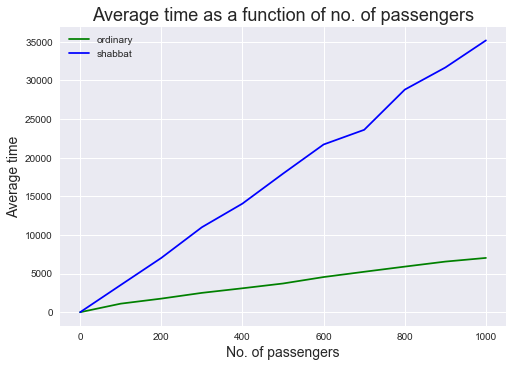

In [94]:
# Compare strategies as the number of passengers increases
shabbat = test_strategy_by_passengers(total_floors = 10, strategy = ElevatorTypes.shabbat)
ordinary = test_strategy_by_passengers(total_floors = 10, strategy = ElevatorTypes.ordinary)
plot_floor_comparison(shabbat, ordinary, comparison_type='num_passengers')

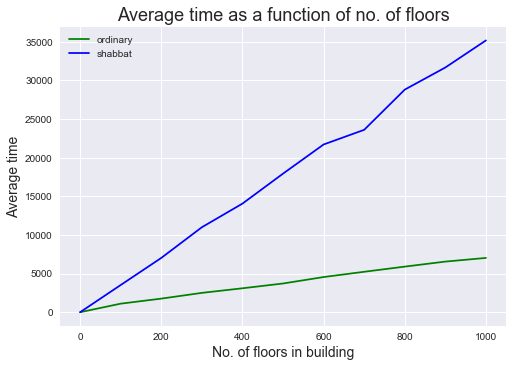

In [88]:
# Compare strategies as the number of floors increases
shabbat = test_strategy_by_floors(num_passengers = 50, strategy = ElevatorTypes.shabbat)
ordinary = test_strategy_by_floors(num_passengers = 50, strategy = ElevatorTypes.ordinary)
plot_floor_comparison(shabbat, ordinary, comparison_type='floors')